### Data Source: 

#### Query
Web of Science Query = (

  TS=(biodivers* OR "biological diversity" OR "bio-divers*" OR "bio divers*")

  OR SU="Biodiversity & Conservation"

)

AND DT=(Article OR Review)

AND PY=(1980-2025)

#### Query Notes
- Period: Starting 1980s since this is period biodiversity as field emerged

- SU = Research Area in WOS: https://webofscience.help.clarivate.com/Content/current-contents/ccc-search-field-tags.htm

In WOS research areas (total 5), Life Science & Biomedicine (1/5) contains only this tag for biodiversity: "Biodiversity & Conservation"

- TS = Topic Search = [Title, Abstract, Author Keywords, Keywords Plus]

Topic search query is kept general here and adopted from 2016 bibliometric assessment here: (See page 2)
https://www.scirp.org/pdf/OJE_2014052617163441.pdf#page=12.10




#### Notes 

- WOS Results returned = 359,435 records

- Time of most recent query: 10 Jul 2025 311pm - 11pm 

- Internal note: Version 2 of query


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib_venn import venn3
from upsetplot import UpSet, from_memberships

from utils.data import load_data
from utils.taxonomy import load_taxonomy

/Users/hunain/d/coding-projects/biodiversity-taxonomy-thesis/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Dataframes

In [2]:
df, df_sample = load_data()
core_cols = [
    "Publication Type", "Article Title", "Language", "Document Type",
    "Author Keywords", "Keywords Plus", "Abstract", 
    "Publisher", "Publisher City", "Publication Date", "Publication Year", 
    "Web of Science Index", "WoS Categories", "Research Areas", 
    "Highly Cited Status", "Hot Paper Status", "UT (Unique WOS ID)"
]
df_core = df[core_cols].copy()

Loading dataset from local file...
Dataset shape: (359435, 72)
 Count Summary : {'row_count': 359435, 'web_of_science_record_count': np.int64(359435), 'web_of_science_record_distinct_count': 358933, 'duplicated_row_count': np.int64(502)}
Dropped 502 duplicated rows. Remaining rows: 358933
Dropped 16449 rows without Abstract. Remaining rows: 342484
Sampling 1000 rows from the dataset of length 342484.
 51 Columns with null values:
Cited References            342484
Meeting Abstract            342484
Book Group Authors          342461
Book Series Subtitle        342445
Group Authors               342178
Book Author Full Names      342068
Book Authors                342068
Conference Host             341191
Highly Cited Status         340300
Hot Paper Status            340300
Supplement                  340024
Conference Sponsor          339945
Part Number                 339633
Book DOI                    339045
Book Series Title           338975
Book Editors                337976
ISBN  

In [3]:
# - Distinct Value Counts
    # - Nulls: Expected to have nulls in "Highly Cited"  and "Hot Paper" since it's "Y or N" only when applicable. Else null.
    # - Keywords are not always given (Keyword plus , author keyword) - ~15-20% rows
    # - Basic details like title, abstract, categories, researach area have no or 1,2 nulls only
distinct_counts = df_core.nunique().sort_values(ascending=False)
null_counts = df_core.isnull().sum()
summary = pd.DataFrame({'distinct': distinct_counts, 'nulls': null_counts[distinct_counts.index]})
print(summary)

                      distinct   nulls
UT (Unique WOS ID)      342484       0
Abstract                342344       0
Article Title           342241       0
Keywords Plus           297609   34066
Author Keywords         290384   51581
Publisher                 3112       0
WoS Categories            2118       2
Research Areas            1549       2
Publisher City            1411       0
Publication Date          1164   40289
Publication Year            46       0
Web of Science Index        45       0
Language                    42       0
Document Type               14       0
Publication Type             3       0
Highly Cited Status          2  340300
Hot Paper Status             2  340300


In [4]:
load_taxonomy(
        zip_path = "gbif_taxonomy/source_files/backbone.zip", 
        extract_to = "gbif_taxonomy/extracted", 
        db_path= "gbif_taxonomy/database/taxon.db"
)

Extraction folder 'gbif_taxonomy/extracted' already exists and is not empty. Skipping extraction.
Loaded 7694320 rows from Taxon.tsv
Database already exists at 'gbif_taxonomy/database/taxon.db'. Skipping save.
SQLite database is available at 'gbif_taxonomy/database/taxon.db' for use.


### S2

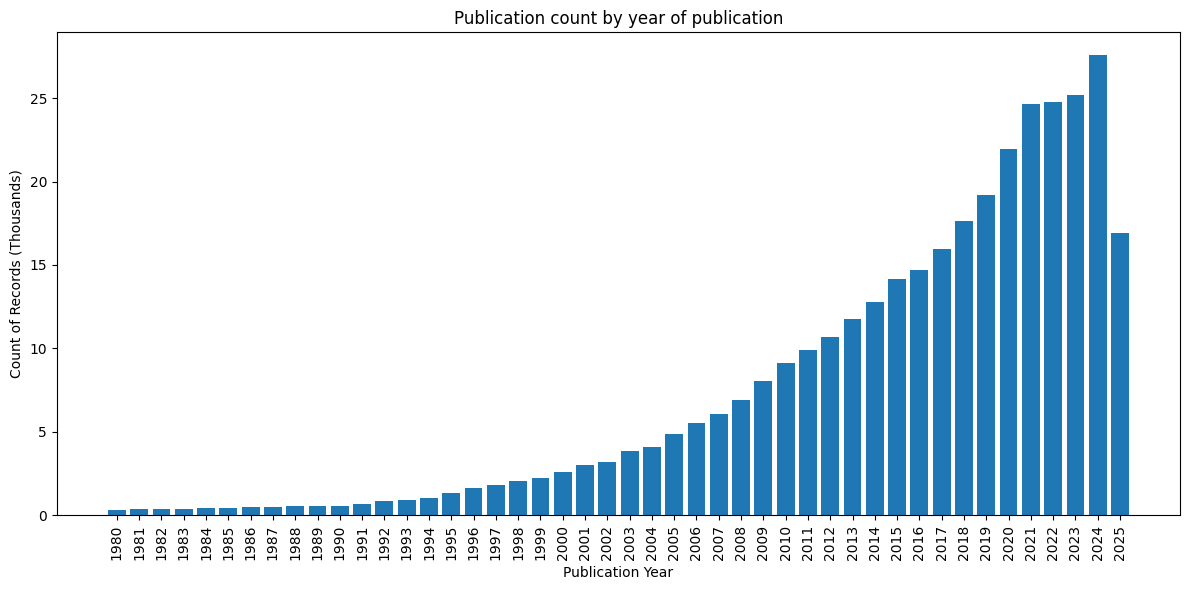

In [14]:
year_counts = df_core['Publication Year'].value_counts().sort_index()
plt.figure(figsize=(12,6))
plt.bar(year_counts.index, year_counts.values / 1000)
plt.xlabel('Publication Year')
plt.ylabel('Count of Records (Thousands)')
plt.title('Publication count by year of publication')
plt.xticks(year_counts.index, rotation=90)
plt.tight_layout()
plt.show()

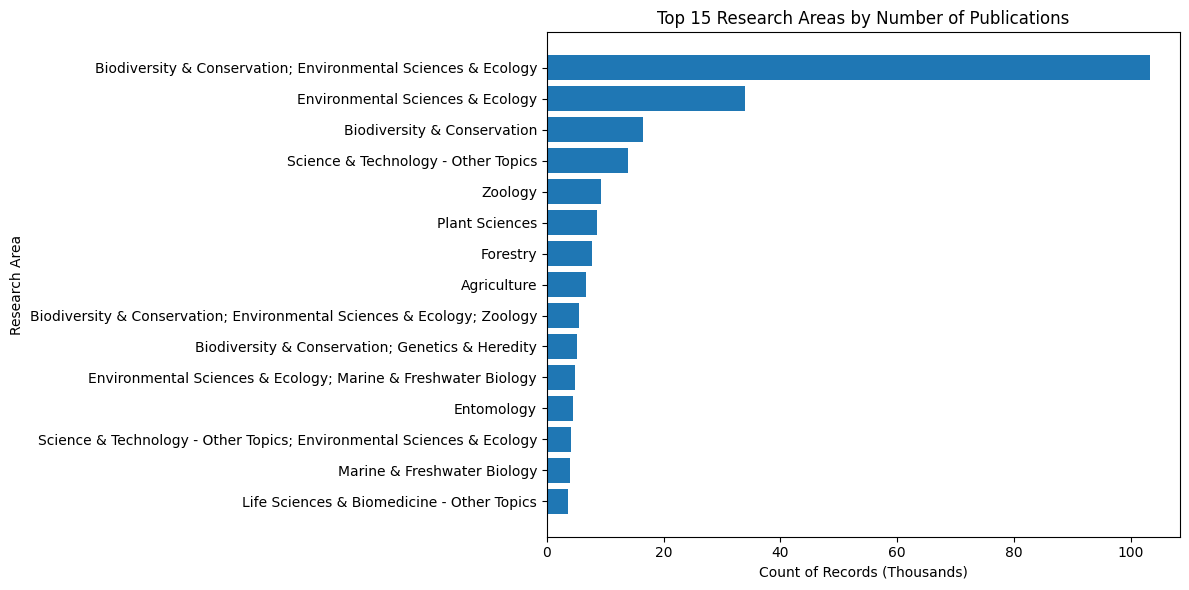

In [15]:
top_research_areas = df_core['Research Areas'].value_counts().head(15)

plt.figure(figsize=(12, 6))
plt.barh(top_research_areas.index[::-1], top_research_areas.values[::-1]/ 1000)  # reverse for top-to-bottom
plt.title("Top 15 Research Areas by Number of Publications")
plt.xlabel('Count of Records (Thousands)')
plt.ylabel("Research Area")
plt.tight_layout()
plt.show()

/Users/hunain/d/coding-projects/biodiversity-taxonomy-thesis/env/lib/python3.13/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/hunain/d/coding-projects/biodiversity-taxonomy-thesis/env/lib/python3.13/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform t

<Figure size 1500x1200 with 0 Axes>

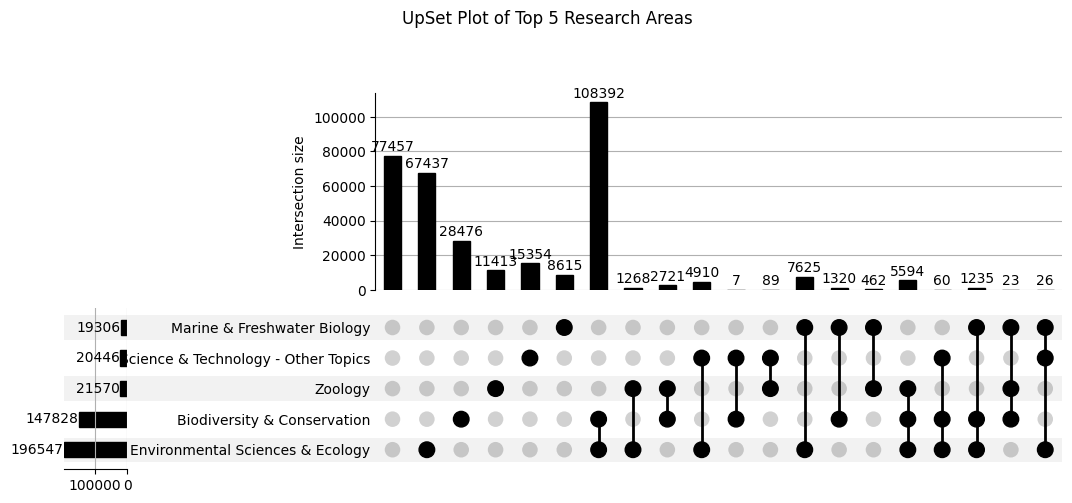

In [62]:
# Step 1: Prepare the Research Areas
research_series = df_core['Research Areas'].fillna("na")
split_research_areas = research_series.str.split(';').apply(lambda x: [i.strip() for i in x])

# Step 2: Create binary indicator matrix
mlb = MultiLabelBinarizer()
indicator_matrix = pd.DataFrame(
    mlb.fit_transform(split_research_areas),
    columns=mlb.classes_,
    index=split_research_areas.index
)

# Step 3: Select top 5 research areas
top_5_areas = indicator_matrix.sum().sort_values(ascending=False).head(5).index.tolist()
subset = indicator_matrix[top_5_areas]

# Step 4: Build memberships
memberships = subset.apply(lambda row: frozenset(area for area in top_5_areas if row[area] == 1), axis=1)

# Step 5: Count how often each unique set of memberships occurs
memberships_list = memberships.tolist()
counts = pd.Series(memberships_list).value_counts()

# Step 6: Convert to valid format for UpSet
upset_data = from_memberships(counts.index.tolist(), data=counts.values)

# Step 6: Plot
plt.figure(figsize=(15, 12))
UpSet(upset_data, show_counts=True).plot()
plt.suptitle("UpSet Plot of Top 5 Research Areas", y=1.05)
plt.tight_layout()
plt.show()

/var/folders/sf/ksfgwr354pl2gjdb_f0yn3vr0000gn/T/ipykernel_69710/2948216019.py:98: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  research_area_matrix = research_area_matrix.groupby(level=0, axis=1).sum()


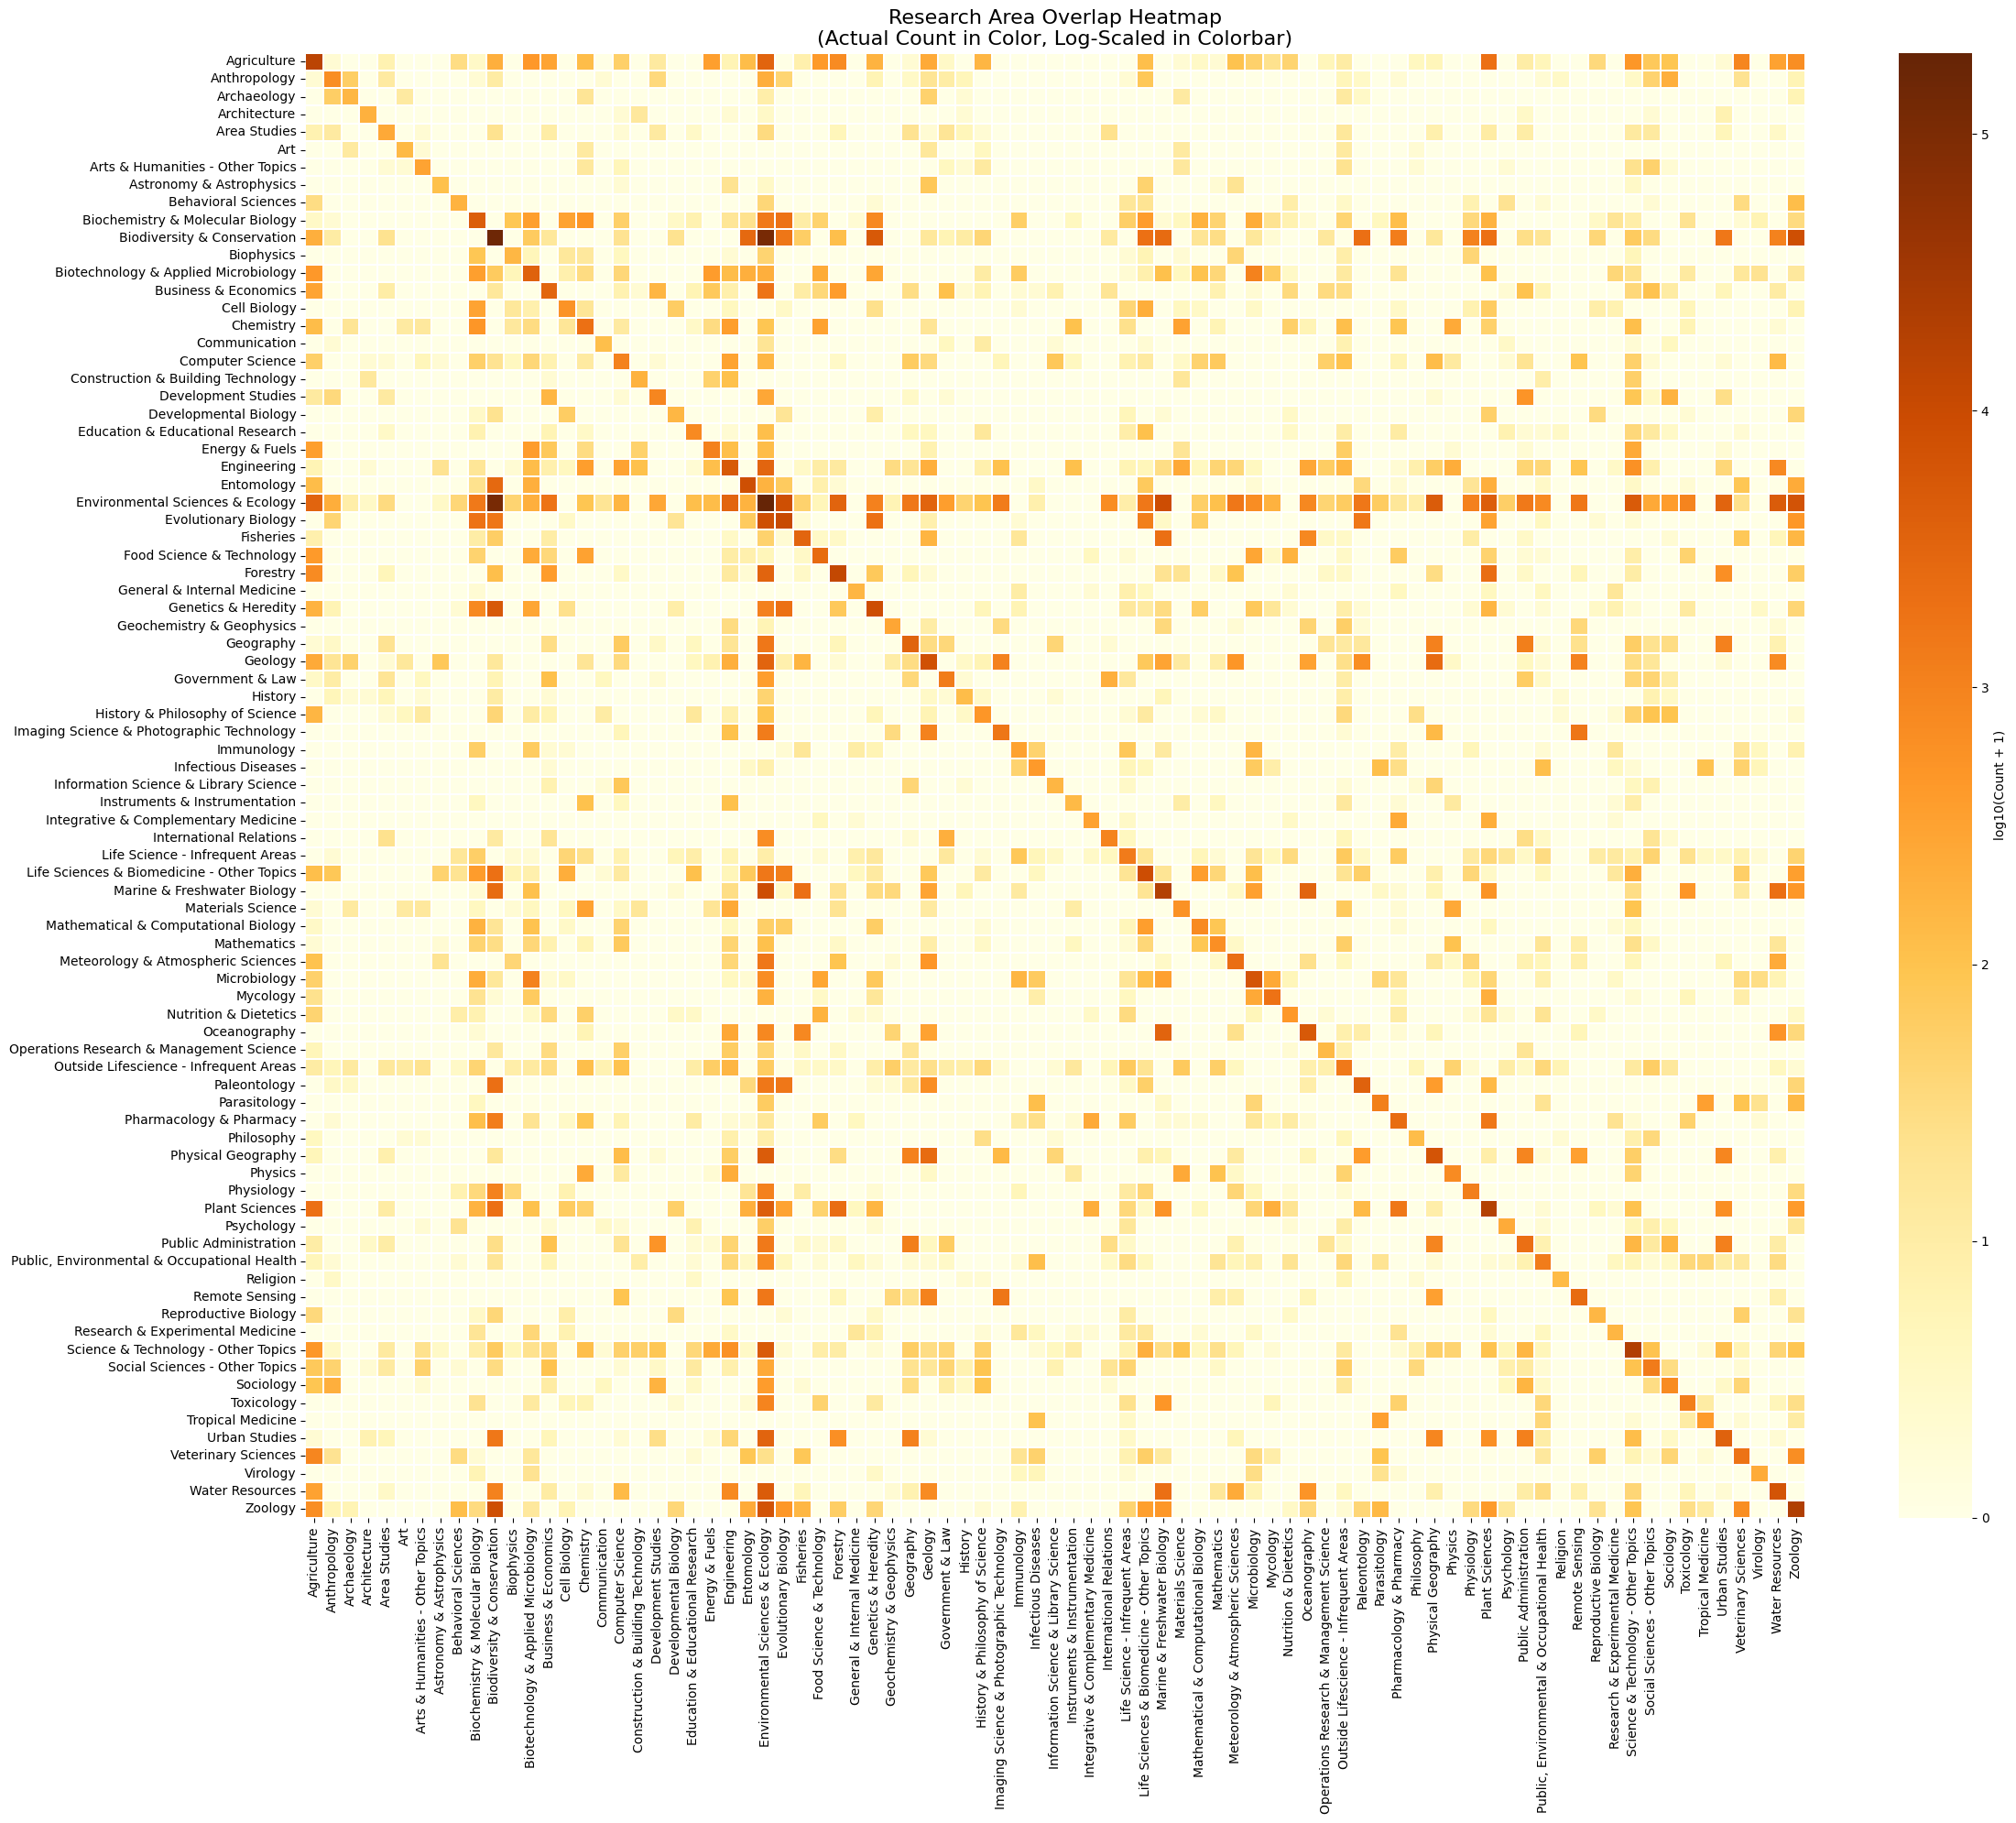

In [47]:
# Split and clean entries
split_research_areas = df_core['Research Areas'].fillna("na").str.split(';').apply(lambda x: [i.strip() for i in x])

# Create binary indicator matrix
mlb = MultiLabelBinarizer()
research_area_matrix = pd.DataFrame(
    mlb.fit_transform(split_research_areas),
    columns=mlb.classes_,
    index=split_research_areas.index


)

# Count number of rows where each research area appears
area_counts = research_area_matrix.sum()

# Mapping for infrequent research areas
infrequent_mapping = {
    'na': 'Outside Lifescience - Infrequent Areas',
    'Transplantation': 'Life Science - Infrequent Areas',
    'Anesthesiology': 'Life Science - Infrequent Areas',
    'Emergency Medicine': 'Life Science - Infrequent Areas',
    'Orthopedics': 'Life Science - Infrequent Areas',
    'Medical Informatics': 'Life Science - Infrequent Areas',
    'Ophthalmology': 'Life Science - Infrequent Areas',
    'Substance Abuse': 'Life Science - Infrequent Areas',
    'Rheumatology': 'Life Science - Infrequent Areas',
    'Otorhinolaryngology': 'Life Science - Infrequent Areas',
    'Rehabilitation': 'Life Science - Infrequent Areas',
    'Surgery': 'Life Science - Infrequent Areas',
    'Sport Sciences': 'Life Science - Infrequent Areas',
    'Nursing': 'Life Science - Infrequent Areas',
    'Audiology & Speech-Language Pathology': 'Life Science - Infrequent Areas',
    'Radiology, Nuclear Medicine & Medical Imaging': 'Life Science - Infrequent Areas',
    'Respiratory System': 'Life Science - Infrequent Areas',
    'Geriatrics & Gerontology': 'Life Science - Infrequent Areas',
    'Urology & Nephrology': 'Life Science - Infrequent Areas',
    'Hematology': 'Life Science - Infrequent Areas',
    'Cardiovascular System & Cardiology': 'Life Science - Infrequent Areas',
    'Obstetrics & Gynecology': 'Life Science - Infrequent Areas',
    'Dentistry, Oral Surgery & Medicine': 'Life Science - Infrequent Areas',
    'Pathology': 'Life Science - Infrequent Areas',
    'Medical Ethics': 'Life Science - Infrequent Areas',
    'Legal Medicine': 'Life Science - Infrequent Areas',
    'Psychiatry': 'Life Science - Infrequent Areas',
    'Dermatology': 'Life Science - Infrequent Areas',
    'Anatomy & Morphology': 'Life Science - Infrequent Areas',
    'Health Care Sciences & Services': 'Life Science - Infrequent Areas',
    'Medical Laboratory Technology': 'Life Science - Infrequent Areas',
    'Pediatrics': 'Life Science - Infrequent Areas',
    'Gastroenterology & Hepatology': 'Life Science - Infrequent Areas',
    'Allergy': 'Life Science - Infrequent Areas',
    'Neurosciences & Neurology': 'Life Science - Infrequent Areas',
    'Endocrinology & Metabolism': 'Life Science - Infrequent Areas',
    'Oncology': 'Life Science - Infrequent Areas',
    'Music': 'Outside Lifescience - Infrequent Areas',
    'Crystallography': 'Outside Lifescience - Infrequent Areas',
    'Film, Radio & Television': 'Outside Lifescience - Infrequent Areas',
    'Family Studies': 'Outside Lifescience - Infrequent Areas',
    'Theater': 'Outside Lifescience - Infrequent Areas',
    'Nuclear Science & Technology': 'Outside Lifescience - Infrequent Areas',
    'Robotics': 'Outside Lifescience - Infrequent Areas',
    'Social Work': 'Outside Lifescience - Infrequent Areas',
    "Women's Studies": 'Outside Lifescience - Infrequent Areas',
    'Asian Studies': 'Outside Lifescience - Infrequent Areas',
    'Ethnic Studies': 'Outside Lifescience - Infrequent Areas',
    'Electrochemistry': 'Outside Lifescience - Infrequent Areas',
    'Microscopy': 'Outside Lifescience - Infrequent Areas',
    'Acoustics': 'Outside Lifescience - Infrequent Areas',
    'Mathematical Methods In Social Sciences': 'Outside Lifescience - Infrequent Areas',
    'Optics': 'Outside Lifescience - Infrequent Areas',
    'Linguistics': 'Outside Lifescience - Infrequent Areas',
    'Metallurgy & Metallurgical Engineering': 'Outside Lifescience - Infrequent Areas',
    'Criminology & Penology': 'Outside Lifescience - Infrequent Areas',
    'Automation & Control Systems': 'Outside Lifescience - Infrequent Areas',
    'Biomedical Social Sciences': 'Outside Lifescience - Infrequent Areas',
    'Demography': 'Outside Lifescience - Infrequent Areas',
    'Transportation': 'Outside Lifescience - Infrequent Areas',
    'Mineralogy': 'Outside Lifescience - Infrequent Areas',
    'Literature': 'Outside Lifescience - Infrequent Areas',
    'Thermodynamics': 'Outside Lifescience - Infrequent Areas',
    'Spectroscopy': 'Outside Lifescience - Infrequent Areas',
    'Cultural Studies': 'Outside Lifescience - Infrequent Areas',
    'Mechanics': 'Outside Lifescience - Infrequent Areas',
    'Mining & Mineral Processing': 'Outside Lifescience - Infrequent Areas',
    'Telecommunications': 'Outside Lifescience - Infrequent Areas',
    'Polymer Science': 'Outside Lifescience - Infrequent Areas',
    'Social Issues': 'Outside Lifescience - Infrequent Areas'
}


# Rename infrequent columns and group (sum) them
new_column_names = {
    col: infrequent_mapping.get(col, col) if area_counts[col] <= 100 else col
    for col in research_area_matrix.columns
}
research_area_matrix = research_area_matrix.rename(columns=new_column_names)
research_area_matrix = research_area_matrix.groupby(level=0, axis=1).sum()

# Recompute co-occurrence matrix
overlap_matrix = research_area_matrix.T.dot(research_area_matrix)

# Apply log10 normalization
log_matrix = np.log10(overlap_matrix + 1)


# Plot heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(log_matrix, cmap="YlOrBr", linewidths=0.1, annot=False, cbar_kws={'label': 'log10(Count + 1)'})
plt.title("Research Area Overlap Heatmap\n(Actual Count in Color, Log-Scaled in Colorbar)", fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
df_sample[core_cols].iloc[1]['Article Title']

'Patch size and colonisation patterns: an experimental analysis using north temperate coprophagous dung beetles'

In [11]:
df_sample[core_cols].iloc[1]['Abstract']

'The relationship between dung pad size and both adult colonisation and larval development was investigated in an assemblage of north temperate dung beetles (Geotrupes, Aphodius and Sphaeridium) using both dung pads and baited pitfall traps. Wet weight of 22-day-old natural dung pads was found to vary widely in the field (<100 g- > 1000 g). Across all sampling dates in field experiments, dung pad size had a significant influence on dung beetle biomass sampled from pads. Closer examination of experimental dung pads on the second day after deposition, when beetle biomass was at a maximum, revealed not only a general positive relationship between pad size and dung beetle biomass but, more importantly, a positive relationship between dung pad size and dung beetle density (dung beetle biomass per unit dung volume). There was a strong trend for Aphodius species richness to increase, and maintain higher values for longer periods of time, in larger pads. Although dung pad and pitfall trap samp